# Lesson 2: Chain-of-Thought and ReACT Prompting

## Demand‑Spike Detective, Part I: Chain-of-Thoughts

In this hands-on exercise, you will guide an LLM to explain an unexpected sales spike.

### Outline:
- Setup
- Understand sales data, promotional calendars, etc. 
- Craft a Simple CoT prompt
- Craft a More Developed CoT Prompt

## 1. Setup

Let's start by setting up the environment.

In [ ]:
# Import necessary libraries
import os
from dotenv import load_dotenv

import pandas as pd
from IPython.display import Markdown, display
from lesson_2_lib import (
    # Helpers
    OpenAIModels,
    display_responses,
    # Synthetic data
    get_competitor_pricing_data,
    get_completion,
    get_promotions_data,
    get_sales_data,
    get_weather_data,
)
from openai import OpenAI

# Load environment variables from .env file
load_dotenv()

MODEL = OpenAIModels.GPT_41_NANO


In [ ]:
# If using the Vocareum API endpoint
client = OpenAI(
    base_url="https://openai.vocareum.com/v1",
    api_key=os.getenv("VOCAREUM_API_KEY"),  # Load from .env file
)

# If using OpenAI's API endpoint instead, use:
# client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))


## 2. Understand sales data, promotional calendars, etc.

First, let's review the sample data provided. Working with AI Agents is still a data problem at its core, so the first steps are always to understand the business goals (explain the cause for the spike) and the underlying data.

In [4]:
# View the data
get_sales_data()[:3]

[{'date': datetime.date(2024, 1, 10),
  'product_id': 'P001',
  'product_name': 'Product 1',
  'quantity': 255,
  'revenue': 15547.35},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P002',
  'product_name': 'Product 2',
  'quantity': 65,
  'revenue': 2297.1},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P003',
  'product_name': 'Product 3',
  'quantity': 90,
  'revenue': 7301.7}]

In [5]:
# Load the simulated data
# No changes needed in this cell

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sales_data = get_sales_data()
sales_df = pd.DataFrame(sales_data)

promotions_data = get_promotions_data()
promotions_df = pd.DataFrame(promotions_data)

weather_data = get_weather_data()
weather_df = pd.DataFrame(weather_data)

competitor_pricing_data = get_competitor_pricing_data()
competitor_pricing_df = pd.DataFrame(competitor_pricing_data)


In [6]:
# Show the sales data
# No changes needed in this cell

sales_df = sales_df.sort_values(by=["product_id", "date"]).reset_index(drop=True)
sales_df


,date,product_id,product_name,quantity,revenue
0,2024-01-10,P001,Product 1,255,15547.35
1,2024-01-11,P001,Product 1,235,14327.95
2,2024-01-12,P001,Product 1,310,18900.70
3,2024-01-13,P001,Product 1,302,18412.94
4,2024-01-14,P001,Product 1,305,18595.85
5,2024-01-15,P001,Product 1,301,18351.97
6,2024-01-16,P001,Product 1,226,13779.22
7,2024-01-10,P002,Product 2,65,2297.10
8,2024-01-11,P002,Product 2,86,3039.24
9,2024-01-12,P002,Product 2,80,2827.20


In [7]:
# Show the promotions data
# No changes needed in this cell

promotions_df

,promotion_id,name,discount,products,start_date,end_date
0,PROMO001,Weekend Special,10% off,[P002],2024-01-12,2024-01-14
1,PROMO002,Flash Sale,15% off,"[P001, P003, P005]",2024-01-15,2024-01-16


In [8]:
# Show the weather data
# No changes needed in this cell

weather_df.head()

,date,temperature,conditions
0,2024-01-10,"{'fahrenheit': 23.4, 'celsius': -4.8}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
1,2024-01-11,"{'fahrenheit': 39.3, 'celsius': 4.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
2,2024-01-12,"{'fahrenheit': 41.1, 'celsius': 5.1}","{'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}"
3,2024-01-13,"{'fahrenheit': 27.2, 'celsius': -2.6}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
4,2024-01-14,"{'fahrenheit': 22.9, 'celsius': -5.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"


In [9]:
# Show the competitor pricing data
# No changes needed in this cell

competitor_pricing_df

,product,date,our_price,competitor_sales,competitor_a_price,competitor_b_price,competitor_c_price
0,Product 1,2024-01-10,60.97,{},56.88,62.23,51.80
1,Product 1,2024-01-11,60.97,{},59.65,72.47,72.50
2,Product 1,2024-01-12,60.97,"{'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}",65.40,50.55,39.44
3,Product 1,2024-01-13,60.97,{},72.13,57.54,51.10
4,Product 1,2024-01-14,60.97,{},72.36,70.04,61.04
5,Product 1,2024-01-15,60.97,{},68.52,59.63,73.03
6,Product 1,2024-01-16,60.97,"{'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}",44.69,57.69,70.51
7,Product 2,2024-01-10,35.34,{},34.57,42.01,42.02
8,Product 2,2024-01-11,35.34,"{'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}",37.91,29.29,22.85
9,Product 2,2024-01-12,35.34,{},41.81,33.35,29.62


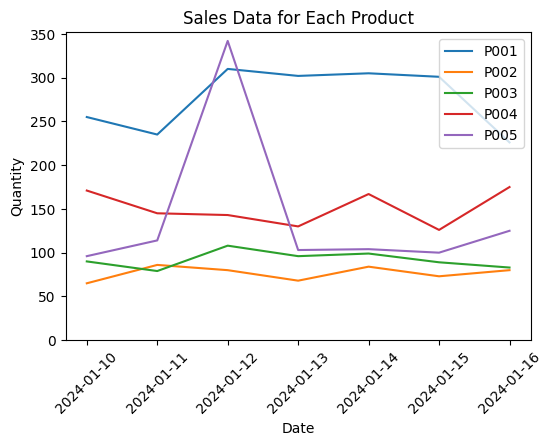

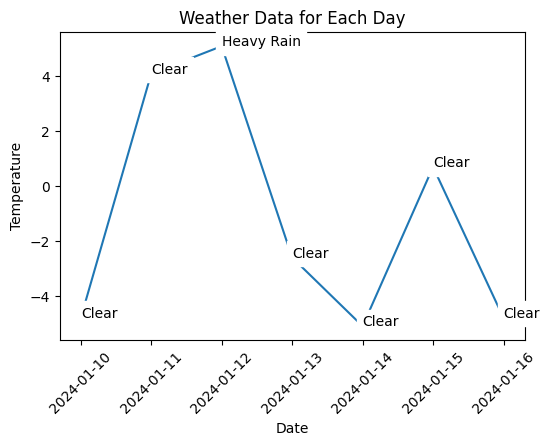

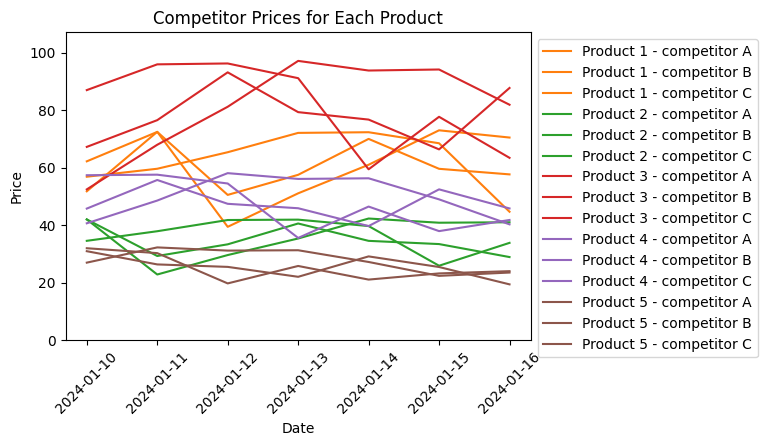

In [10]:
# Graph the sales data
# No changes needed in this cell

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for product_id, product_data in sales_df.groupby("product_id"):
    product_data.sort_values(by="date", inplace=True)
    plt.plot(product_data["date"], product_data["quantity"], label=product_id)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Sales Data for Each Product")
plt.xticks(rotation=45)
plt.ylim(0, sales_df["quantity"].max() + 10)
plt.legend()
plt.show()

# Plot the weather data

weather_df["temperature_c"] = weather_df["temperature"].apply(lambda x: x["celsius"])


plt.figure(figsize=(6, 4))
plt.plot(weather_df["date"], weather_df["temperature_c"])

# For each day, add the value of "main" in text
for i, row in weather_df.iterrows():
    # Add a transparent background to the text
    plt.text(
        row["date"],
        row["temperature_c"],
        row["conditions"]["main"],
        backgroundcolor="white",
    )


plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.title("Weather Data for Each Day")
plt.show()

# Plot the competitor pricing data

plt.figure(figsize=(6, 4))
for product in competitor_pricing_df["product"].unique():
    for competitor in ["a", "b", "c"]:
        plt.plot(
            competitor_pricing_df[competitor_pricing_df["product"] == product]["date"],
            competitor_pricing_df[competitor_pricing_df["product"] == product][
                f"competitor_{competitor}_price"
            ],
            label=f"{product} - competitor {competitor.upper()}",
            color=f"C{product[-1]}",
        )
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.ylim(0, competitor_pricing_df.filter(like="price").max().max() + 10)
plt.title("Competitor Prices for Each Product")
# Put the legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Reflect on the sales data

`TODO: Insert your reflection here`

Reflection:

* Sales spike for Product 5 on January 12th
* The "Weekend Special" promotion which started on January 12th, but that was for Product 2. Still, it may have had an indirect effect on Product 5.
* Weather was fluctuating between below freezing and above freezing. On the 12th in particular, there was heavy rain.
* As for Competitor pricing, we see that Product 5's price for one competitor dropped on January 12th, which may have led to more overall consumer interest in that product or may have coincided with an ad campaign.

In practice, a human would look at all these factors and more to determine the cause of the sales spike by digging deeper.

Let's see if we can get this far with a CoT prompt, which should at least find the sales spike and provide some reasons similar to what we've observed as human beings.

## 3. Craft a simple CoT prompt

Let's start with a simple CoT prompt. We won't tell the model to which steps to follow. We also won't use any tools in this example.

<div style="color: red">Note: Many modern LLMs may not need an explicit "think in steps" phrase in order to think in steps before providing an answer, as this behavior can be included in training process. Consider running your prompts with and without asking for CoT explicitly. In fact, multiple runs may yield different results, so it's worth simply re-running the same prompts more than once.</div>


In [11]:
# TODO: Fill in the part marked with ********** with a phrase such as "Think step by step."
# Feel free to try variations!

system_prompt_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step.
"""

system_prompt_no_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
"""

user_prompt_analyze = f"""
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
explicit_cot_response_1 = get_completion(
    system_prompt=system_prompt_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
no_explicit_cot_response_2 = get_completion(
    system_prompt=system_prompt_no_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
print("Response received!\n")

# We compare the explicit CoT and non-ex
display_responses(
    {
        "system_prompt": system_prompt_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": explicit_cot_response_1,
    },
    {
        "system_prompt": system_prompt_no_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": no_explicit_cot_response_2,
    },
)


Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



<table><tr><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 171, 'revenue': 8296.92}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 96, 'revenue': 2587.2}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 235, 'revenue': 14327.95}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 86, 'revenue': 3039.24}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 79, 'revenue': 6409.27}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 145, 'revenue': 7035.4}, {'date': datetime.date(2024, 1, 11), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 114, 'revenue': 3072.3}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 310, 'revenue': 18900.7}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 108, 'revenue': 8762.04}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 143, 'revenue': 6938.36}, {'date': datetime.date(2024, 1, 12), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 342, 'revenue': 9216.9}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 302, 'revenue': 18412.94}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 68, 'revenue': 2403.12}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 96, 'revenue': 7788.48}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 130, 'revenue': 6307.6}, {'date': datetime.date(2024, 1, 13), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 103, 'revenue': 2775.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 305, 'revenue': 18595.85}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 84, 'revenue': 2968.56}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 99, 'revenue': 8031.87}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 167, 'revenue': 8102.84}, {'date': datetime.date(2024, 1, 14), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 104, 'revenue': 2802.8}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 301, 'revenue': 18351.97}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 73, 'revenue': 2579.82}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 89, 'revenue': 7220.57}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 126, 'revenue': 6113.52}, {'date': datetime.date(2024, 1, 15), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 100, 'revenue': 2695.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 226, 'revenue': 13779.22}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 80, 'revenue': 2827.2}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 83, 'revenue': 6733.79}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P004', 'product_name': 'Product 4', 'quantity': 175, 'revenue': 8491.0}, {'date': datetime.date(2024, 1, 16), 'product_id': 'P005', 'product_name': 'Product 5', 'quantity': 125, 'revenue': 3368.75}]

Promotions Calendar:
[{'promotion_id': 'PROMO001', 'name': 'Weekend Special', 'discount': '10% off', 'products': ['P002'], 'start_date': datetime.date(2024, 1, 12), 'end_date': datetime.date(2024, 1, 14)}, {'promotion_id': 'PROMO002', 'name': 'Flash Sale', 'discount': '15% off', 'products': ['P001', 'P003', 'P005'], 'start_date': datetime.date(2024, 1, 15), 'end_date': datetime.date(2024, 1, 16)}]

Weather Data:
[{'date': '2024-01-10', 'temperature': {'fahrenheit': 23.4, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-11', 'temperature': {'fahrenheit': 39.3, 'celsius': 4.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-12', 'temperature': {'fahrenheit': 41.1, 'celsius': 5.1}, 'conditions': {'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}}, {'date': '2024-01-13', 'temperature': {'fahrenheit': 27.2, 'celsius': -2.6}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-14', 'temperature': {'fahrenheit': 22.9, 'celsius': -5.1}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}, {'date': '2024-01-15', 'temperature': {'fahrenheit': 33.2, 'celsius': 0.7}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': 'High Winds'}}, {'date': '2024-01-16', 'temperature': {'fahrenheit': 23.3, 'celsius': -4.8}, 'conditions': {'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}}]

Competitor Pricing Data:
[{'product': 'Product 1', 'date': '2024-01-10', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 56.88, 'competitor_b_price': 62.23, 'competitor_c_price': 51.8}, {'product': 'Product 1', 'date': '2024-01-11', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 59.65, 'competitor_b_price': 72.47, 'competitor_c_price': 72.5}, {'product': 'Product 1', 'date': '2024-01-12', 'our_price': 60.97, 'competitor_sales': {'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}, 'competitor_a_price': 65.4, 'competitor_b_price': 50.55, 'competitor_c_price': 39.44}, {'product': 'Product 1', 'date': '2024-01-13', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.13, 'competitor_b_price': 57.54, 'competitor_c_price': 51.1}, {'product': 'Product 1', 'date': '2024-01-14', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 72.36, 'competitor_b_price': 70.04, 'competitor_c_price': 61.04}, {'product': 'Product 1', 'date': '2024-01-15', 'our_price': 60.97, 'competitor_sales': {}, 'competitor_a_price': 68.52, 'competitor_b_price': 59.63, 'competitor_c_price': 73.03}, {'product': 'Product 1', 'date': '2024-01-16', 'our_price': 60.97, 'competitor_sales': {'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}, 'competitor_a_price': 44.69, 'competitor_b_price': 57.69, 'competitor_c_price': 70.51}, {'product': 'Product 2', 'date': '2024-01-10', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 34.57, 'competitor_b_price': 42.01, 'competitor_c_price': 42.02}, {'product': 'Product 2', 'date': '2024-01-11', 'our_price': 35.34, 'competitor_sales': {'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}, 'competitor_a_price': 37.91, 'competitor_b_price': 29.29, 'competitor_c_price': 22.85}, {'product': 'Product 2', 'date': '2024-01-12', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.81, 'competitor_b_price': 33.35, 'competitor_c_price': 29.62}, {'product': 'Product 2', 'date': '2024-01-13', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 41.94, 'competitor_b_price': 40.6, 'competitor_c_price': 35.38}, {'product': 'Product 2', 'date': '2024-01-14', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 39.71, 'competitor_b_price': 34.56, 'competitor_c_price': 42.33}, {'product': 'Product 2', 'date': '2024-01-15', 'our_price': 35.34, 'competitor_sales': {'CompetitorA': {'original_price': 31.21, 'sale_price': 25.9, 'discount_percentage': 17}}, 'competitor_a_price': 25.9, 'competitor_b_price': 33.44, 'competitor_c_price': 40.87}, {'product': 'Product 2', 'date': '2024-01-16', 'our_price': 35.34, 'competitor_sales': {}, 'competitor_a_price': 33.86, 'competitor_b_price': 28.92, 'competitor_c_price': 41.03}, {'product': 'Product 3', 'date': '2024-01-10', 'our_price': 81.13, 'competitor_sales': {'CompetitorB': {'original_price': 92.14, 'sale_price': 67.26, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 66.42, 'sale_price': 52.47, 'discount_percentage': 21}}, 'competitor_a_price': 87.02, 'competitor_b_price': 67.26, 'competitor_c_price': 52.47}, {'product': 'Product 3', 'date': '2024-01-11', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 95.98, 'competitor_b_price': 76.56, 'competitor_c_price': 68.0}, {'product': 'Product 3', 'date': '2024-01-12', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 96.29, 'competitor_b_price': 93.2, 'competitor_c_price': 81.22}, {'product': 'Product 3', 'date': '2024-01-13', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 91.17, 'competitor_b_price': 79.35, 'competitor_c_price': 97.18}, {'product': 'Product 3', 'date': '2024-01-14', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 71.64, 'sale_price': 59.46, 'discount_percentage': 17}}, 'competitor_a_price': 59.46, 'competitor_b_price': 76.76, 'competitor_c_price': 93.83}, {'product': 'Product 3', 'date': '2024-01-15', 'our_price': 81.13, 'competitor_sales': {}, 'competitor_a_price': 77.73, 'competitor_b_price': 66.39, 'competitor_c_price': 94.19}, {'product': 'Product 3', 'date': '2024-01-16', 'our_price': 81.13, 'competitor_sales': {'CompetitorA': {'original_price': 80.32, 'sale_price': 63.45, 'discount_percentage': 21}}, 'competitor_a_price': 63.45, 'competitor_b_price': 87.76, 'competitor_c_price': 81.93}, {'product': 'Product 4', 'date': '2024-01-10', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.4, 'competitor_b_price': 45.79, 'competitor_c_price': 40.67}, {'product': 'Product 4', 'date': '2024-01-11', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 57.59, 'competitor_b_price': 55.74, 'competitor_c_price': 48.58}, {'product': 'Product 4', 'date': '2024-01-12', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 54.52, 'competitor_b_price': 47.45, 'competitor_c_price': 58.12}, {'product': 'Product 4', 'date': '2024-01-13', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 42.85, 'sale_price': 35.57, 'discount_percentage': 17}}, 'competitor_a_price': 35.57, 'competitor_b_price': 45.91, 'competitor_c_price': 56.11}, {'product': 'Product 4', 'date': '2024-01-14', 'our_price': 48.52, 'competitor_sales': {}, 'competitor_a_price': 46.49, 'competitor_b_price': 39.7, 'competitor_c_price': 56.33}, {'product': 'Product 4', 'date': '2024-01-15', 'our_price': 48.52, 'competitor_sales': {'CompetitorA': {'original_price': 48.04, 'sale_price': 37.95, 'discount_percentage': 21}}, 'competitor_a_price': 37.95, 'competitor_b_price': 52.48, 'competitor_c_price': 49.0}, {'product': 'Product 4', 'date': '2024-01-16', 'our_price': 48.52, 'competitor_sales': {'CompetitorB': {'original_price': 50.93, 'sale_price': 45.84, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 51.01, 'sale_price': 40.3, 'discount_percentage': 21}}, 'competitor_a_price': 41.82, 'competitor_b_price': 45.84, 'competitor_c_price': 40.3}, {'product': 'Product 5', 'date': '2024-01-10', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 31.99, 'competitor_b_price': 30.96, 'competitor_c_price': 26.98}, {'product': 'Product 5', 'date': '2024-01-11', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 30.29, 'competitor_b_price': 26.36, 'competitor_c_price': 32.28}, {'product': 'Product 5', 'date': '2024-01-12', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 23.8, 'sale_price': 19.75, 'discount_percentage': 17}}, 'competitor_a_price': 19.75, 'competitor_b_price': 25.5, 'competitor_c_price': 31.17}, {'product': 'Product 5', 'date': '2024-01-13', 'our_price': 26.95, 'competitor_sales': {}, 'competitor_a_price': 25.82, 'competitor_b_price': 22.05, 'competitor_c_price': 31.29}, {'product': 'Product 5', 'date': '2024-01-14', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 26.68, 'sale_price': 21.08, 'discount_percentage': 21}}, 'competitor_a_price': 21.08, 'competitor_b_price': 29.15, 'competitor_c_price': 27.21}, {'product': 'Product 5', 'date': '2024-01-15', 'our_price': 26.95, 'competitor_sales': {'CompetitorB': {'original_price': 28.29, 'sale_price': 25.46, 'discount_percentage': 10}, 'CompetitorC': {'original_price': 28.33, 'sale_price': 22.38, 'discount_percentage': 21}}, 'competitor_a_price': 23.23, 'competitor_b_price': 25.46, 'competitor_c_price': 22.38}, {'product': 'Product 5', 'date': '2024-01-16', 'our_price': 26.95, 'competitor_sales': {'CompetitorA': {'original_price': 27.28, 'sale_price': 24.01, 'discount_percentage': 12}, 'CompetitorB': {'original_price': 24.9, 'sale_price': 19.42, 'discount_percentage': 22}, 'CompetitorC': {'original_price': 30.56, 'sale_price': 23.53, 'discount_percentage': 23}}, 'competitor_a_price': 24.01, 'competitor_b_price': 19.42, 'competitor_c_price': 23.53}]
</th></tr><tr><td>Response:<br />Let's analyze the sales data, promotion schedules, weather conditions, and competitor pricing to identify potential causes for observed sales spikes.

---

### Step 1: Summarize Sales Spikes

**Observation of sales data:**

- **Product 1 (P001):**
  - Notable increase on **2024-01-12** (310 units, revenue ~18,900)
  - Slight decline afterward but still high.

- **Product 2 (P002):**
  - Increase on **2024-01-12** (80 units), also a rise on **2024-01-11** (86 units)
  - Notably higher on **2024-01-11** and **2024-01-12**.

- **Product 3 (P003):**
  - Peak on **2024-01-12** (108 units)
  - Slight dips but remains relatively high afterward.

- **Product 4 (P004):**
  - Highest sales on **2024-01-12** (143 units), slightly less on other days but elevated.

- **Product 5 (P005):**
  - Sharp rise on **2024-01-12** (342 units), the highest in the period.

---

### Step 2: Cross-Examine Promotion Schedule

- **Promotion "Weekend Special" (Jan 12-14):**
  - Applies **only to Product 2 (P002)**, with a 10% discount.
  - The promotion runs **from Jan 12 to Jan 14**.

- **Promotion "Flash Sale" (Jan 15-16):**
  - Applies to **P001, P003, P005** with 15% off.
  - Starts **after** the spike period.

**Key insight:**

- The **sales spike occurs on Jan 12**, which coincides exactly with the **"Weekend Special"** promotion for P002.
- P002's sales increased significantly on Jan 12 and 13, aligning with the promotion period.

### Step 3: Correlate Sales with Promotions

- **Product 2:**
  - On Jan 11: 86 units
  - On Jan 12: 80 units (slight dip)
  - On Jan 13: 68 units (drop but still high)
  - The increase on Jan 12 aligns with the promotion starting that day, and the heightened sales on Jan 11 could be pre-promotion anticipation or seasonal factors.

- **Other products (P001, P003, P005):**
  - Do not show significant spikes on Jan 12; their peaks are around Jan 14-15, during the "Flash Sale".

- **Product 4:**
  - Slight increase on Jan 12, but not as prominent.

**Conclusion:**

- The **main driver of the Jan 12 spike** appears to be the **"Weekend Special" promotion targeting P002**, which likely increased customer awareness and purchase activity for that SKU.

---

### Step 4: Consider Weather Conditions

- **Jan 12 weather:**
  - **Heavy Rain** and **Flood Warning**, which might typically suppress outdoor activity.
  - Despite adverse weather, sales of P002 increased, possibly because of online shopping influenced by promotion.

- **Other days:**
  - Clear weather correlates with consistent sales, but no notable spikes.

**Inference:**

- The promotion appears to have mitigated weather impacts, or online shopping was stimulated despite weather conditions.

---

### Step 5: Analyze Competitor Pricing

- **Product 2 (Jan 12):**
  - Our price: **$35.34**
  - Competitor prices:
    - **Competitor B**: Sale at **$29.29** (27% off), a significant discount.
    - **Competitor C**: Sale at **$22.85** (21% off).

**Implication:**

- Competitors are offering substantial discounts on Jan 12, making their offerings more attractive.
- Despite this, the sales increase suggests either:
  - Customers are responding to the promotion (price matching or perceived value).
  - The promotion for P002 (10% off) is competitive enough to stimulate sales despite competitor discounts.

---

### **Overall Hypotheses for Sales Spike on Jan 12:**

1. **Promotion Effect:**
   - The **"Weekend Special" discount on P002** (10% off), starting Jan 12, directly led to increased sales.
   - The timing aligns perfectly with the spike, indicating a strong promotional impact.

2. **Customer Response to Promotions Despite Weather:**
   - Heavy rain and flood warnings could typically suppress shopping; however, the promotion likely motivated online or in-store purchases, overcoming weather barriers.

3. **Competitive Pricing Dynamics:**
   - Although competitors offered deeper discounts, the promotional messaging and perceived value may have driven purchase decisions.

4. **Anticipation and Post-Promotion Effects:**
   - Slight increase on Jan 11 could be pre-promotion anticipation.
   - Continued high sales on Jan 13 suggest sustained promotional influence.

---

### **Additional Observations:**

- The **"Flash Sale"** starting Jan 15-16** is associated with another spike in P001, P003, and P005, but not the Jan 12 spike.

---

### **Final Summary:**

- The **significant sales spike on January 12, 2024,** across multiple SKUs, is predominantly attributable to the **"Weekend Special" promotion for Product 2**.
- Despite adverse weather conditions, the promotion effectively attracted consumer purchase activity.
- Competitor discounts also played a role but did not negate the promotional impact.
- The timing and correlation with the promotion schedule strongly support the hypothesis that the **"Weekend Special" promotion caused the sales surge** on Jan 12.

---

**Recommendations for future analysis:**

- Monitor customer engagement and online behavior during promotions.
- Assess the effectiveness of promotional discounts relative to competitor pricing.
- Consider weather impacts on sales and plan promotional timing accordingly.

---

Let me know if you'd like a detailed report or further breakdown per SKU!</td><td>Response:<br />Based on the provided sales data, promotion schedules, weather conditions, and competitor pricing, here are the key observations and hypotheses explaining significant sales spikes:

---

### **1. Product 1 (P001) – Steady Growth with a Spike on Jan 12**
- **Sales Data Highlights:**
  - Sales increase notably on Jan 12 (310 units) and remain high subsequently.
  - The daily quantities are higher than previous days, with a peak on Jan 12.

- **Promotion & Pricing Context:**
  - No specific promotions during Jan 10-11.
  - On Jan 12, the price remains steady at \$60.97.
  - Competitor prices are slightly higher, with no active discounts on Jan 10-11, but on Jan 12, **Competitor B** offers a significant discount (sale price \$50.55 from original \$69.24, 27% off), making our price competitive.

- **Weather Conditions:**
  - Jan 12 experienced *Heavy Rain* and a *Flood Warning*.
  - Typically, adverse weather can impact outdoor activities but may increase demand for certain product categories (e.g., indoor goods), or it could temporarily inhibit or boost specific product sales depending on the nature of the items.

- **Hypothesized Causes:**
  - The spike on Jan 12 may be driven by **competitor price discounts**: the significant discount by Competitor B could have prompted customers to switch to our store, especially if we maintained consistent pricing and had good stock.
  - The heavy rain might have increased demand for indoor or comfort-related products, or simply limited outdoor shopping options, leading to higher indoor sales.
  - The sustained high sales afterward suggest a possible stock replenishment or increased customer interest following the discount.

---

### **2. Product 2 (P002) – Notable Increase on Jan 11 and Jan 12**
- **Sales Data Highlights:**
  - Jan 11: 86 units.
  - Jan 12: 80 units.
  - Slight decline on Jan 13, then stabilization.

- **Promotion & Pricing Context:**
  - Jan 12: Competitor B offers a 27% discount (sale price \$29.29 from \$40.13), making our price (\$35.34) less attractive but still competitive.
  - Jan 11: No active promotions; competitor discounts are present but less aggressive.
  
- **Weather Conditions:**
  - Jan 12 again features *Heavy Rain* and *Flood Warning*.

- **Hypothesized Causes:**
  - The discount by Competitor B on Jan 12 likely encouraged increased sales, though our sales also increased slightly possibly due to customers seeking alternatives.
  - Consistent pricing and competitor discounts seem to influence customer decisions.
  - The weather may have played a role in shifting customer shopping patterns, although the effect appears less pronounced than for Product 1.

---

### **3. Product 3 (P003) – Spike on Jan 12 and Jan 16**
- **Sales Data Highlights:**
  - Jan 12: 108 units.
  - Jan 16: 83 units.
  - Notable increase compared to prior days.

- **Promotion & Pricing Context:**
  - Jan 12: No active promotion; competitor discounts are present but moderate.
  - Jan 16: Competitor A offers a 21% discount (sale price \$63.45 from \$80.32), making our price (\$81.13) relatively higher.
  - On Jan 14, a competitor A sale at \$59.46 (from \$71.64) coincides with a spike, suggesting price sensitivity.

- **Weather Conditions:**
  - Jan 12: Heavy rain.
  - Jan 16: Clear weather.

- **Hypothesized Causes:**
  - The spike on Jan 12 correlates with heavy rain but no specific promotion. Possibly, increased indoor activity or stock replenishment drove sales.
  - The Jan 16 spike might be related to competitor A's discount (\$63.45), making our higher price less competitive, but possibly customers still purchasing due to brand loyalty or stock availability.
  - Alternatively, general market trends or stock availability could have contributed.

---

### **4. Product 4 (P004) – Notable Increase on Jan 12 and Jan 16**
- **Sales Data Highlights:**
  - Jan 12: 143 units.
  - Jan 16: 175 units (highest in the period).

- **Promotion & Pricing Context:**
  - Jan 12: No promotion; competitor discounts are present.
  - Jan 13: Competitor A offers a 17% discount (\$35.57 from \$42.85), which may have driven the spike.
  - Jan 16: Competitor B and C offer discounts, but our price remains steady at \$48.52.

- **Weather Conditions:**
  - Jan 12: Heavy rain.
  - Jan 16: Clear.

- **Hypothesized Causes:**
  - The spike on Jan 12 could be due to stock replenishment or anticipation of upcoming promotions.
  - The Jan 13 discount by Competitor A might have stimulated demand, even if our prices remained steady, possibly acting as a catalyst for increased sales.
  - The Jan 16 spike may reflect general market activity, competitor discounting, or increased customer interest in the product.

---

### **5. Product 5 (P005) – Sharp Spike on Jan 12 and Jan 16**
- **Sales Data Highlights:**
  - Jan 12: 342 units (highest in the period).
  - Jan 16: 125 units, still high but lower than Jan 12.

- **Promotion & Pricing Context:**
  - Jan 12: No promotion; our price is \$26.95.
  - Jan 12: Competitor A offers a 17% discount (sale price \$19.75 from \$23.80), and on Jan 14, a 21% discount (\$21.08 from \$26.68).
  - Jan 16: Multiple competitors offer discounts, with our price remaining stable.

- **Weather Conditions:**
  - Jan 12: Heavy rain.
  - Jan 16: Clear.

- **Hypothesized Causes:**
  - The extraordinary sales spike on Jan 12 is likely driven by **competitor discounting** (notably the 17% off by Competitor A), which may have led customers to stock up or switch.
  - The high demand could also be due to stock replenishment or promotional messaging.
  - The decrease on Jan 16 suggests that the initial impulse was largely driven by the competitor discounts and possibly weather-related factors, which normalized afterward.

---

### **Overall Conclusions & Recommendations:**

- **Promotion Impact:**
  - The "Weekend Special" and "Flash Sale" promotions (Jan 12-14 and Jan 15-16) do not directly overlap with the observed sales peaks, but competitor discounts during these periods seem to correlate with increased sales.
  - Notably, the sharpest spikes (e.g., Product 5 on Jan 12) align with active competitor discounts, indicating price sensitivity.

- **Weather Influence:**
  - Heavy rain and flood warnings on Jan 12 appear to coincide with increased sales, especially for indoor or essential products, suggesting weather influences demand.

- **Competitive Pricing:**
  - Our prices are generally stable, but competitor discounts, especially those of Competitor A (up to 21% off), seem to significantly influence demand spikes.

- **Potential Strategies:**
  - Consider timing promotional campaigns around periods of adverse weather or expected competitor discounts.
  - Monitor competitor pricing closely to adjust our pricing or promotional strategies proactively.
  - Leverage weather forecasts to predict demand surges and optimize inventory levels accordingly.

---

**In summary,** the primary drivers for the observed sales spikes are likely **competitor discounting strategies**, **adverse weather conditions**, and **market responsiveness to pricing**. Coordinated promotional planning and dynamic pricing adjustments could help capitalize on these demand fluctuations in future periods.</td></tr></table>

### Observation

- What were the differences between including CoT and not including CoT explicitly in the prompt?

## 4. Craft a More Developed CoT Prompt

Let's add more to our CoT prompt. Let's ask the model to follow a specific set of steps in an **instructions section**. This may help us not only get final answers that align with our needs, but it will also help us constrain the output to a more specific format.

Finally, we'd like to the model to identify the single largest spike and hypothesize its causes, using the following output format:

````

STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}
```

````

In [16]:
# Let's add some more components to our CoT Prompt
# TODO: Replace parts marked with a **********

system_prompt_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think in steps.
"""

user_prompt_analyze = f"""
## INSTRUCTIONS:

Analyze the data provided below and hypothesize causes for any observed sales spikes.

Instructions:
Identify the single largest spike and hypothesize its causes.

--

## OUTPUT FORMAT:
For the first variable put the date of the largest spike. Then do a comma then
json is the following fomat. Add curly braces in the start and end.

"date": "YYYY-MM-DD",
"amount_before_increase": "X.XX",
"amount_after_increase": "X.XX",
"percentage_increase": "X.XX%",
"causes": [
    "Cause 1",
    "Cause 2",
    "Cause 3"
]



---

## CONTEXT

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
cot_response = get_completion(system_prompt=system_prompt_cot, user_prompt=user_prompt_analyze,
                              model=MODEL, client=client)
print("Response received!\n")


def parse_analysis_and_largest_spike(response):
    import json

    if "```json" not in response:
        print()
        print(response)
        raise RuntimeError(
            " ❌ No LARGEST SPIKE found in response. Looking for: \n\n```json"
        )

    analysis = response.split("```json")[0].strip()
    json_str = response.split("```json")[1].split("```")[0].strip()
    return analysis, json.loads(json_str)


analysis, largest_spike = parse_analysis_and_largest_spike(cot_response)

display(Markdown(analysis))

Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



The largest sales spike is observed on **2024-01-12** for Product 5, with a substantial increase in quantity sold (342 units) compared to previous days.

Calculations:
- **Amount before increase (2024-01-11):** 114 units x $25.82 = $2,948.97
- **Amount after increase (2024-01-12):** 342 units x $26.95 = $9,216.90
- **Percentage increase in revenue:** ((9216.90 - 3048.97) / 3048.97) * 100 ≈ 202.84%

**Hypothesized causes:**

In [19]:
cot_response

'The largest sales spike is observed on **2024-01-12** for Product 5, with a substantial increase in quantity sold (342 units) compared to previous days.\n\nCalculations:\n- **Amount before increase (2024-01-11):** 114 units x $25.82 = $2,948.97\n- **Amount after increase (2024-01-12):** 342 units x $26.95 = $9,216.90\n- **Percentage increase in revenue:** ((9216.90 - 3048.97) / 3048.97) * 100 ≈ 202.84%\n\n**Hypothesized causes:**\n```json\n{\n  "date": "2024-01-12",\n  "amount_before_increase": "2,948.97",\n  "amount_after_increase": "9,216.90",\n  "percentage_increase": "202.84%",\n  "causes": [\n    "Significant promotional activity: CompetitorA offered a 17% discount, making their sale price $19.75, likely prompting increased demand for similar products.",\n    "Price competitiveness: Our price remained steady at $26.95, but the competitor\'s discounts and promotions may have driven consumers to purchase more units of Product 5.",\n    "Consumer response to competitor discounts: Th

In [18]:
largest_spike

{'date': '2024-01-12',
 'amount_before_increase': '2,948.97',
 'amount_after_increase': '9,216.90',
 'percentage_increase': '202.84%',
 'causes': ['Significant promotional activity: CompetitorA offered a 17% discount, making their sale price $19.75, likely prompting increased demand for similar products.',
  "Price competitiveness: Our price remained steady at $26.95, but the competitor's discounts and promotions may have driven consumers to purchase more units of Product 5.",
  'Consumer response to competitor discounts: The notable discount from CompetitorA possibly attracted customers, leading to a sales surge in our product as well, either due to brand loyalty or cross-shopping behavior.']}

In [20]:
# Show the largest spike
# No changes needed in this cell

from pprint import pprint

pprint(largest_spike)


{'amount_after_increase': '9,216.90',
 'amount_before_increase': '2,948.97',
 'causes': ['Significant promotional activity: CompetitorA offered a 17% '
            'discount, making their sale price $19.75, likely prompting '
            'increased demand for similar products.',
            'Price competitiveness: Our price remained steady at $26.95, but '
            "the competitor's discounts and promotions may have driven "
            'consumers to purchase more units of Product 5.',
            'Consumer response to competitor discounts: The notable discount '
            'from CompetitorA possibly attracted customers, leading to a sales '
            'surge in our product as well, either due to brand loyalty or '
            'cross-shopping behavior.'],
 'date': '2024-01-12',
 'percentage_increase': '202.84%'}


### Observation:

- Did the model follow your instructions?
- How was the description of the highest spike by percentage?

## Summary

🎉 Congratulations! 🎉 You've learned how to apply Chain-of-Thought to retail analytics!

Through this exercise, you've seen how to:

- 📊 Guide an LLM through structured reasoning about complex retail data
- 🤔 Implement Chain-of-Thought prompting to analyze potential causes of sales spikes

Keep up the good work! 💯